# Analysis of monthly return data

## Description

- Calculate mean return per Style

In [98]:
import feather
import numpy as np
import datetime
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import sparse

In [2]:
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [3]:
from sklearn.cluster import KMeans, MiniBatchKMeans, DBSCAN
from sklearn.cluster import AffinityPropagation

from sklearn.preprocessing import Normalizer, MaxAbsScaler

# Setup

In [393]:
# Convert to date format
begin_date = '2018-01-01' 
end_date = '2019-01-01'

## Load Data

### Returns

In [394]:
path = '../data/processed/EDY/returns_s.feather'
returns = feather.read_dataframe(path)
returns.shape

# Convert to date format and filter based on date
returns['date'] =  pd.to_datetime(returns['caldt'], format='%Y-%m-%d')
returns = returns[returns['date'] > begin_date]

### Summary

In [395]:
path = '../data/processed/EDY/holdings_summary_s.feather'
summary = feather.read_dataframe(path)
summary.shape

(15391, 13)

In [396]:
# Convert to date format and filter based on date with mask that is also used on holdings
summary['date'] =  pd.to_datetime(summary['report_dt'], format='%Y-%m-%d')
date_mask = summary['date'] > begin_date
summary = summary[date_mask]
summary.shape

(4244, 14)

### Holdings

In [397]:
path = '../data/processed/EDY/holdings_s.npz'
holdings = sparse.load_npz(path)
holdings.shape

(15391, 8995)

In [398]:
holdings = holdings[date_mask.values]

In [399]:
print('Shape of summary information')
print(summary.shape)
print('Shape of holding information')
print(holdings.shape)

Shape of summary information
(4244, 14)
Shape of holding information
(4244, 8995)


### portno_map

In [400]:
path = '../data/raw/portno_map.feather'
portno_map = feather.read_dataframe(path)

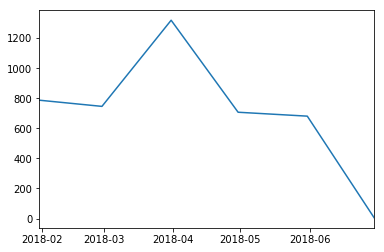

In [401]:
summary['report_dt'].value_counts().plot()

## Merge Crsp_Obj_Cd onto returns data

### Merge does not take dates into account -> TODO

In [402]:
returns_merged = returns.merge(summary, how='left', left_on='crsp_fundno',right_on='fund_no')
returns_merged.shape

(136092, 18)

In [403]:
returns_merged = returns_merged.dropna(axis = 0, how = 'any')
returns_merged.shape

(48251, 18)

In [404]:
returns_merged.sample()

,crsp_fundno,caldt,mret,date_x,level_0,index,port_no,report_dt,index_fund_flag,et_flag,lipper_class,mutual_fund,sample,cap_class,style_class,crsp_portno,fund_no,date_y
31634,16705.0,2018-01-31,0.069579,2018-01-31,17289.0,214885,1022067.0,2018-03-31,MF,MF,LCCE,Y,Y,L,C,1022067.0,16705.0,2018-03-31


#### Take only needed columns and reorder them

In [405]:
returns_merged = returns_merged[['caldt','fund_no','port_no','mret','lipper_class','style_class','cap_class']]

In [406]:
returns_merged.sample()

,caldt,fund_no,port_no,mret,lipper_class,style_class,cap_class
607,2018-05-31,3023.0,1025916.0,0.048017,SCCE,C,S


## Check for how many funds returns data is available

#### TODO

## Calc mean return per Obj_cd

### Get unique codes for later

In [407]:
group_by = 'style_class'

In [408]:
obj_codes = returns_merged[[group_by]].drop_duplicates()
obj_codes = obj_codes[group_by].values

In [409]:
returns_merged.sample(1)

,caldt,fund_no,port_no,mret,lipper_class,style_class,cap_class
38941,2018-01-31,20126.0,1022323.0,0.065773,LCVE,V,L


In [410]:
# Analysis of selected funds
returns_obj = returns_merged.groupby([group_by,'caldt'])['mret'].agg(['mean','count','std'])

In [411]:
def cumreturn(series):
    """
    Calculate cumreturn from a pandas series
    
    Attention: Sets first return observation to 1
    Could be better implemented
    """
    min_date = series.index.min()
    series.loc[min_date] = 0
    series = (series.fillna(0)+1).cumprod()
    return(series)

In [412]:
returns_obj['cumret'] = returns_obj.groupby(group_by)[['mean']].apply(cumreturn)

#### Pivot to make multiple columns, one for each obj_cd

In [413]:
returns_obj_n = returns_obj.pivot_table(
        values='cumret', 
        index=['caldt'], 
        columns=group_by)

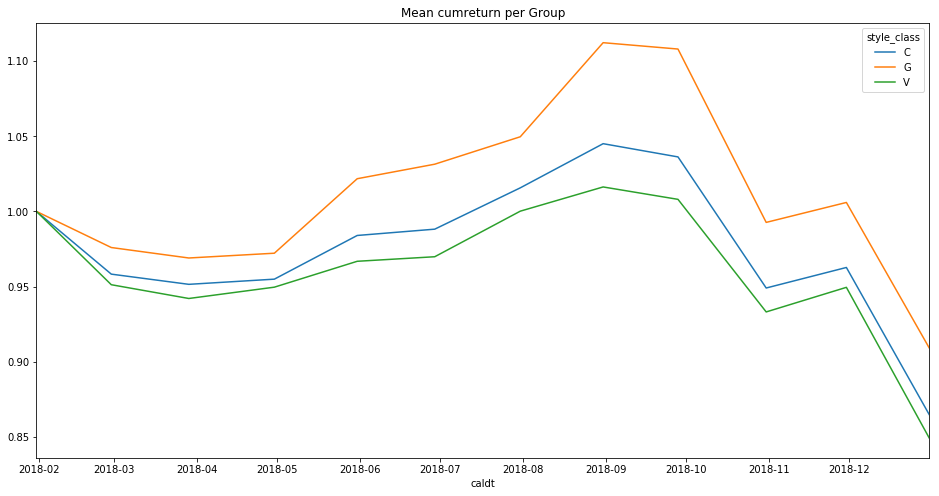

In [414]:
returns_obj_n.plot(
              kind='line',
              use_index=True,
              figsize=(16,8),
              title='Mean cumreturn per Group',
              legend='best')